In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import sys
import multiprocessing as mp

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn.utils import shuffle
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-w', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-x', '--in_dir', type=str, help='input_directory')
parser.add_argument('-y', '--cell_name', type=str, help='name of the cell')
parser.add_argument('-z', '--out_dir', type=str, help='output_directory')
parser.add_argument('-a', '--track1_peaks', type=str, help='chromatin accessibility peak')
parser.add_argument('-b', '--track2_peaks', type=str, help='ChIP-seq H3K27ac peak')
parser.add_argument('-c', '--track3_peaks', type=str, help='ChIP-seq H3K4me3 peak')
parser.add_argument('-d', '--track4_peaks', type=str, help='ChIP-seq H3K9ac peak')
parser.add_argument('-e', '--track5_peaks', type=str, help='ChIP-seq H3K4me1 peak')
parser.add_argument('-f', '--track1_bw', type=str, help='chromatin accessibility bigWig')
parser.add_argument('-g', '--track2_bw', type=str, help='ChIP-seq H3K27ac bigWig')
parser.add_argument('-i', '--track3_bw', type=str, help='ChIP-seq H3K4me3 bigWig')
parser.add_argument('-j', '--track4_bw', type=str, help='ChIP-seq H3K9ac bigWig')
parser.add_argument('-k', '--track5_bw', type=str, help='ChIP-seq H3K4me1 bigWig')

cell_type = "NPC"

#simulate command line input
seqdir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/" + cell_type + "/"
cmdline_str='-w ' + " HepG2,K562,A549,HCT116,MCF-7 " + \
    ' -x ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/DNase/" + \
    ' -y ' + "NPC" + \
    ' -z ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/output/" + \
    ' -a ' + seqdir+cell_type+".DNase-seq.narrowPeak" + \
    ' -b ' + seqdir+cell_type+".ChIP-seq.H3K27ac.narrowPeak" + \
    ' -c ' + seqdir+cell_type+".ChIP-seq.H3K4me3.narrowPeak" + \
    ' -d ' + seqdir+cell_type+".ChIP-seq.H3K9ac.narrowPeak" + \
    ' -e ' + seqdir+cell_type+".ChIP-seq.H3K4me1.narrowPeak" + \
    ' -f ' + seqdir+cell_type+".DNase-seq.bigWig" + \
    ' -g ' + seqdir+cell_type+".ChIP-seq.H3K27ac.bigWig" + \
    ' -i ' + seqdir+cell_type+".ChIP-seq.H3K4me3.bigWig" + \
    ' -j ' + seqdir+cell_type+".ChIP-seq.H3K9ac.bigWig" + \
    ' -k ' + seqdir+cell_type+".ChIP-seq.H3K4me1.bigWig"

seq_names = ["DNase", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
            
for key, value in vars(args).items():
    if key == "cell_types" or key == "in_dir" or key == "out_dir" or key == "cell_name":
        continue
    else:
        if not os.path.exists(value):
            print(key + " argument file does not exist")
            exit(1)
print("all files found!")

#construct a set of autosome + X chromosome names
chromosomes = []
for i in range(1,23):
    chromosomes.append("chr"+str(i))
chromosomes.append("chrX")
print(chromosomes)
print("all files found!")

all files found!
['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
all files found!


In [5]:
#load in original bed from prediction
encode_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/NPC/NPC.ENCODE_cCRE.bed")

#load in fantom NSC
fan_nsc_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/neuronal_stem_cell_differentially_expressed_enhancers.bed.mapped.hg38.bed").sort()

#load in fantom gen
fan_gen_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/human_permissive_enhancers_phase_1_and_2.bed.mapped.hg38.bed").sort()

#load in original bed from prediction
original_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.bed")

#load in bed refined by grad cam
refined_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.bed")

ENCODE cCRE has a total coverage of 253321371 bp
FANTOM human has a total coverage of 18398234 bp
FANTOM NSC has a total coverage of 88514 bp
original prediction has a total coverage of 69202000 bp
refined prediction has a total coverage of 8726800 bp


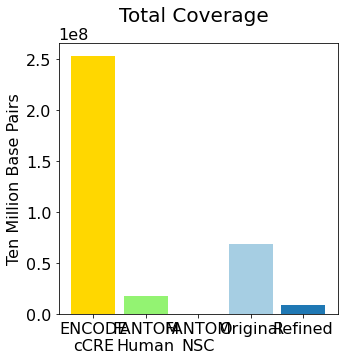

In [8]:
print("ENCODE cCRE has a total coverage of", encode_bed.total_coverage(), "bp")
print("FANTOM human has a total coverage of", fan_gen_bed.total_coverage(), "bp")
print("FANTOM NSC has a total coverage of", fan_nsc_bed.total_coverage(), "bp")
print("original prediction has a total coverage of", original_bed.total_coverage(), "bp")
print("refined prediction has a total coverage of", refined_bed.total_coverage(), "bp")
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(5, 5))
plt.bar(np.array([0, 0.3, 0.6, 0.9, 1.2]), 
        np.array([encode_bed.total_coverage(),
                  fan_gen_bed.total_coverage(),
                  fan_nsc_bed.total_coverage(),
                  original_bed.total_coverage(), 
                  refined_bed.total_coverage()]), 
        width = 0.25,
        align='center',
        color = ["#FFD700", "#93F372", "#72F3CE", "#A6CEE3", "#1F78B4"])
plt.xticks(np.array([0, 0.3, 0.6, 0.9, 1.2]), np.array(["ENCODE\ncCRE", "FANTOM\nHuman", "FANTOM\nNSC", 
                                                        "Original", "Refined"]))
fig.suptitle('Total Coverage', fontsize=20)
plt.ylabel('Ten Million Base Pairs', fontsize=16)
plt.savefig('DECODE.total_coverage.pdf')

In [44]:
eQTLs = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/eQTLs/DER-08b_hg38_eQTL.bonferroni.txt"
cQTLs = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/eQTLs/DER-09_hg38_cQTL.significant.txt"

In [46]:
eQTL_df = pd.read_csv(eQTLs, sep="\t")
cQTL_df = pd.read_csv(cQTLs, sep="\t")
eQTL_df = eQTL_df.groupby(["SNP_chr", "SNP_start", "SNP_end"]).size().reset_index(name='Freq')
cQTL_df = cQTL_df.groupby(["SNP_chr", "SNP_start", "SNP_end"]).size().reset_index(name='Freq')
eQTL_df.to_csv(eQTLs.replace("txt", "bed"), sep="\t", header=False, index=False)
cQTL_df.to_csv(cQTLs.replace("txt", "bed"), sep="\t", header=False, index=False)

a total of 439169 eQTL snps
original prediction has 11789 overlap with eQTL snps
refined prediction has 1858 overlap with eQTL snps


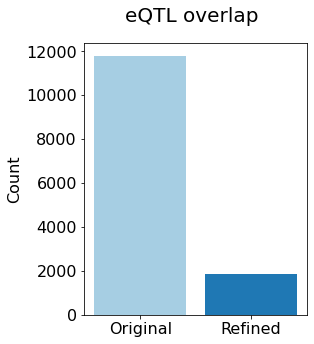

In [47]:
#compare eQTL overlap
eQTL_snps = pybedtools.BedTool(eQTLs.replace("txt", "bed")).sort().merge()
print("a total of", eQTL_snps.count(), "eQTL snps")
print("original prediction has", original_bed.intersect(eQTL_snps).count(), "overlap with eQTL snps")
print("refined prediction has", refined_bed.intersect(eQTL_snps).count(), "overlap with eQTL snps")
fig = plt.figure(figsize=(4, 5))
plt.bar(np.array([0, 0.3]), 
        np.array([original_bed.intersect(eQTL_snps).count(), 
                  refined_bed.intersect(eQTL_snps).count()]), 
        width = 0.25,
        color = ["#A6CEE3", "#1F78B4"])
plt.xticks(np.array([0, 0.3]), np.array(["Original", "Refined"]))
fig.suptitle('eQTL overlap', fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.savefig('DECODE.eQTL.pdf')

a total of 1903 cQTL snps
original prediction has 93 overlap with cQTL snps
refined prediction has 19 overlap with cQTL snps


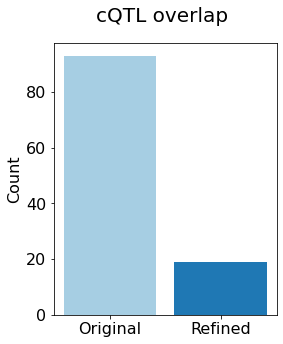

In [48]:
#compare cQTL overlap
cQTL_snps = pybedtools.BedTool(cQTLs.replace("txt", "bed")).sort().merge()
print("a total of", cQTL_snps.count(), "cQTL snps")
print("original prediction has", original_bed.intersect(cQTL_snps).count(), "overlap with cQTL snps")
print("refined prediction has", refined_bed.intersect(cQTL_snps).count(), "overlap with cQTL snps")
fig = plt.figure(figsize=(4, 5))
plt.bar(np.array([0, 0.3]), 
        np.array([original_bed.intersect(cQTL_snps).count(), 
                  refined_bed.intersect(cQTL_snps).count()]), 
        width = 0.25,
        color = ["#A6CEE3", "#1F78B4"])
plt.xticks(np.array([0, 0.3]), np.array(["Original", "Refined"]))
fig.suptitle('cQTL overlap', fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.savefig('DECODE.cQTL.pdf')

In [49]:
genome_size = 3049315783 # biostars.org/p/186666/
eQTL_number = eQTL_snps.count()
eQTL_sp = eQTL_number / genome_size
cQTL_number = cQTL_snps.count()
cQTL_sp = cQTL_number / genome_size
from scipy import stats

eqtl_op = []
eqtl_pval = []
cqtl_op = []
cqtl_pval = []
for i in [encode_bed, fan_gen_bed, fan_nsc_bed, original_bed, refined_bed]:
    eqtl_op.append(i.intersect(eQTL_snps).count()/i.total_coverage())
    cqtl_op.append(i.intersect(cQTL_snps).count()/i.total_coverage())
    eQTL_test = stats.binom_test(i.intersect(eQTL_snps).count(), n=i.total_coverage(), p=eQTL_sp, alternative='greater')
    cQTL_test = stats.binom_test(i.intersect(cQTL_snps).count(), n=i.total_coverage(), p=cQTL_sp, alternative='greater')
    eqtl_pval.append(eQTL_test)
    cqtl_pval.append(cQTL_test)

print(eqtl_op)
print(eqtl_pval)
print(cqtl_op)
print(cqtl_pval)

[0.00016567887594450134, 0.00016218947970767194, 0.00015816706961610592, 0.00017035634808242536, 0.00021290736581564834]
[2.3447050689139332e-173, 1.0233172301472515e-10, 0.3992687591835361, 1.1300668421248476e-70, 1.27141134244627e-56]
[1.1132104602418245e-06, 1.141413898747021e-06, 0.0, 1.3438917950348255e-06, 2.1772012650685245e-06]
[4.604226205238858e-19, 0.007380355258683519, 1.0, 3.410488895946391e-11, 4.685609067784791e-06]


In [32]:
phastCons = pyBigWig.open("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/hg38.phastCons100way.bw")

encode_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in encode_bed]
fan_nsc_pahstCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in fan_nsc_bed]
fan_gen_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in fan_gen_bed]
original_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in original_bed]
refined_pahstCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in refined_bed]

encode_phastCons = np.nan_to_num(np.array(encode_phastCons))
fan_nsc_pahstCons = np.nan_to_num(np.array(fan_nsc_pahstCons))
fan_gen_phastCons = np.nan_to_num(np.array(fan_gen_phastCons))
original_phastCons = np.nan_to_num(np.array(original_phastCons))
refined_pahstCons = np.nan_to_num(np.array(refined_pahstCons))

print("ENCODE cCRE prediction phastCons score is", np.median(encode_phastCons))
print("Fantom NSC prediction phastCons score is", np.median(fan_nsc_pahstCons))
print("Fantom Human prediction phastCons score is", np.median(fan_gen_phastCons))
print("original prediction phastCons score is", np.median(original_phastCons))
print("refined prediction phastCons score is", np.median(refined_pahstCons))


ENCODE cCRE prediction phastCons score is 0.05090410768357362
Fantom NSC prediction phastCons score is 0.0201740011381124
Fantom Human prediction phastCons score is 0.04563991702112464
original prediction phastCons score is 0.09216967104412493
refined prediction phastCons score is 0.11769781306605129


0.00e+00
0.00e+00


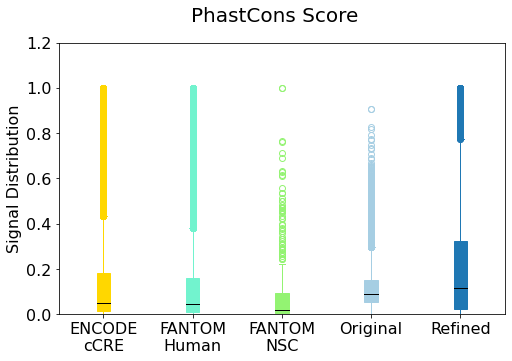

In [71]:
t, p = f_oneway(original_phastCons, refined_pahstCons)
print('{:.2e}'.format(p))

t, p = ttest_ind(original_phastCons, refined_pahstCons)
print('{:.2e}'.format(p))

# fig = plt.figure(figsize=(4, 5))
# box = plt.boxplot(np.array([np.array(original_phastCons), 
#                             np.array(refined_pahstCons)]), 
#                   labels=np.array(["Original", "Refined"]),
#                   boxprops=dict(color="#A6CEE3"),
#                   patch_artist=True, notch=True)
# fig.suptitle('PhastCons Score (p-value=' + str(p) + ")", fontsize=20)
# plt.ylabel('Signal Distribution', fontsize=16)

# colors = ["#A6CEE3", "#1F78B4"]

# plt.show();

fig = plt.figure(figsize=(8, 5))
c = "#FFD700"
box1 = plt.boxplot(np.array(encode_phastCons), positions=[1], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
plt.setp(box1["medians"], color="black")

c3 = "#72F3CE"
box3 = plt.boxplot(np.array(fan_gen_phastCons), 
                   positions=[2],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box3[item], color=c3)
plt.setp(box3["boxes"], facecolor=c3)
plt.setp(box3["medians"], color="black")
plt.setp(box3["fliers"], markeredgecolor=c3)

c4 = "#93F372"
box4 = plt.boxplot(np.array(fan_nsc_pahstCons), 
                   positions=[3],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box4[item], color=c4)
plt.setp(box4["boxes"], facecolor=c4)
plt.setp(box4["medians"], color="black")
plt.setp(box4["fliers"], markeredgecolor=c4)

c1 = "#A6CEE3"
box1 = plt.boxplot(np.array(original_phastCons), 
                   positions=[4],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c1)
plt.setp(box1["boxes"], facecolor=c1)
plt.setp(box1["medians"], color="black")
plt.setp(box1["fliers"], markeredgecolor=c1)


c2 = "#1F78B4"
box2 = plt.boxplot(np.array(refined_pahstCons), 
                   positions=[5],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box2[item], color=c2)
plt.setp(box2["boxes"], facecolor=c2)
plt.setp(box2["medians"], color="black")
plt.setp(box2["fliers"], markeredgecolor=c2)

plt.ylabel('Signal Distribution', fontsize=16)
fig.suptitle('PhastCons Score', fontsize=20)
plt.ylim(0, 1.2)
plt.xticks([1, 2, 3, 4, 5], ['ENCODE\ncCRE', 'FANTOM\nHuman', 'FANTOM\nNSC', 'Original', 'Refined'])
plt.savefig('DECODE.phastCONs.pdf')
plt.show();

# fig = plt.figure(figsize=(4, 5))
# plt.bar(np.array(["Original", "Refined"]), np.array([np.sum(original_phastCons), np.sum(refined_pahstCons)]))
# fig.suptitle('PhastCons Score', fontsize=20)
# plt.ylabel('Total Signal', fontsize=16)

In [8]:
#hg19 genome lift over
liftOver = "~/liftOver "
hg38_original = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.bed "
hg38_2_hg19_chain = "~/hg38ToHg19.over.chain "
hg19_lifted = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed "
hg19_unlift = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.unlift.bed "
os.system(liftOver + hg38_original + hg38_2_hg19_chain + hg19_lifted + hg19_unlift)

liftOver = "~/liftOver "
hg38_original = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.bed "
hg38_2_hg19_chain = "~/hg38ToHg19.over.chain "
hg19_lifted = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed "
hg19_unlift = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.unlift.bed "
os.system(liftOver + hg38_original + hg38_2_hg19_chain + hg19_lifted + hg19_unlift)

0

In [36]:
#load in original bed from prediction
encode_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/exp_validation/NPC_input/NPC.ENCODE_cCRE.hg19.mapped.bed")

#load in original bed from prediction
original_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed")

#load in bed refined by grad cam
refined_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed")

#load in fantom nsc bed from prediction
fan_nsc_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/neuronal_stem_cell_differentially_expressed_enhancers.bed.sorted.hg19.bed")

#load in fantom gen bed from prediction
fan_gen_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/human_permissive_enhancers_phase_1_and_2.bed.sorted.hg19.bed")


In [37]:
gnomadrare="/gpfs/slayman/pi/gerstein/yy555/Project/RareDAF_redo/New_data_set_9/GetLocal_2/data/gnomad.rare.noncoding.bw"
gnomadcomm="/gpfs/slayman/pi/gerstein/yy555/Project/RareDAF_redo/New_data_set_9/GetLocal_2/data/gnomad.comm.noncoding.bw"
pcawgrare="/gpfs/slayman/pi/gerstein/yy555/Project/RareDAF_redo/Variant_rare_comm_3/variant_bigwig/pcawg.noncoding.rare.0.0004.bw"
pcawgcomm="/gpfs/slayman/pi/gerstein/yy555/Project/RareDAF_redo/Variant_rare_comm_3/variant_bigwig/pcawg.noncoding.comm.0.01.bw"

rare_daf = [gnomadrare, gnomadcomm, pcawgrare, pcawgcomm]
original_daf = []
refined_daf = []
encode_daf = []
fan_nsc_daf = []
fan_gen_daf = []

for r in rare_daf:
    rare_daf_bw = pyBigWig.open(r)
    
    original_raredaf = []
    original_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed").sort()
    for x in original_bed:
        try:
            results = np.nansum(rare_daf_bw.values(x.chrom, x.start, x.stop))
        except:
            continue
        original_raredaf.append(results)
    print("original done")
    
    refined_raredaf = []
    refined_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed").sort()
    for x in refined_bed:
        try:
            results = np.nansum(rare_daf_bw.values(x.chrom, x.start, x.stop))
        except:
            continue
        refined_raredaf.append(results)
    print("refined done")
    
    encode_raredaf = []
    encode_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/exp_validation/NPC_input/NPC.ENCODE_cCRE.hg19.mapped.bed").sort()
    for x in encode_bed:
        try:
            results = np.nansum(rare_daf_bw.values(x.chrom, x.start, x.stop))
        except:
            continue
        encode_raredaf.append(results)
    print("encode done")
    
    fan_nsc_raredaf = []
    fan_nsc_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/neuronal_stem_cell_differentially_expressed_enhancers.bed.sorted.hg19.bed").sort()
    for x in fan_nsc_bed:
        try:
            results = np.nansum(rare_daf_bw.values(x.chrom, x.start, x.stop))
        except:
            continue
        fan_nsc_raredaf.append(results)
    print("fan nsc done")
    
    fan_gen_raredaf = []
    fan_gen_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/human_permissive_enhancers_phase_1_and_2.bed.sorted.hg19.bed")
    for x in fan_gen_bed:
        try:
            results = np.nansum(rare_daf_bw.values(x.chrom, x.start, x.stop))
        except:
            continue
        fan_gen_raredaf.append(results)
    print("fan gen done")
    
    
    original_signal = np.sum(np.nan_to_num(np.array(original_raredaf)))
    refined_signal = np.sum(np.nan_to_num(np.array(refined_raredaf)))
    encode_signal = np.sum(np.nan_to_num(np.array(encode_raredaf)))
    fan_nsc_signal = np.sum(np.nan_to_num(np.array(fan_nsc_raredaf)))
    fan_gen_signal = np.sum(np.nan_to_num(np.array(fan_gen_raredaf)))
    
    original_daf.append(original_signal)
    refined_daf.append(refined_signal)
    fan_nsc_daf.append(fan_nsc_signal)
    fan_gen_daf.append(fan_gen_signal)
    encode_daf.append(encode_signal)
    
    print(original_signal, refined_signal, encode_signal, fan_nsc_signal, fan_gen_signal)

original done
refined done
encode done
fan nsc done
fan gen done
3025052.0 444817.0 11202636.0 3633.0 829181.0
original done
refined done
encode done
fan nsc done
fan gen done
302967.0 36007.0 1102787.0 384.0 82681.0
original done
refined done
encode done
fan nsc done
fan gen done
1204207.0 164501.0 4443713.0 1453.0 331819.0
original done
refined done
encode done
fan nsc done
fan gen done
225744.0 26034.0 823010.0 312.0 61803.0


In [64]:
gnomad_refined = refined_daf[0] / (refined_daf[0] + refined_daf[1])
gnomad_original = original_daf[0] / (original_daf[0] + original_daf[1])
gnomad_nsc = fan_nsc_daf[0] / (fan_nsc_daf[0] + fan_nsc_daf[1])
gnomad_human = fan_gen_daf[0] / (fan_gen_daf[0] + fan_gen_daf[1])
gnomad_encode = encode_daf[0] / (encode_daf[0] + encode_daf[1])
print(np.array([gnomad_encode,
                  gnomad_human, 
                  gnomad_nsc,
                  gnomad_original,
                  gnomad_refined
                 ]))

[0.91038203 0.90932729 0.90440627 0.90896476 0.92511397]


In [65]:
pcawg_refined = refined_daf[2] / (refined_daf[2] + refined_daf[3])
pcawg_original = original_daf[2] / (original_daf[2] + original_daf[3])
pcawg_nsc = fan_nsc_daf[2] / (fan_nsc_daf[2] + fan_nsc_daf[3])
pcawg_human = fan_gen_daf[2] / (fan_gen_daf[2] + fan_gen_daf[3])
pcawg_encode = encode_daf[2] / (encode_daf[2] + encode_daf[3])
print(np.array([pcawg_encode,
                  pcawg_human, 
                  pcawg_nsc,
                  pcawg_original,
                  pcawg_refined
                 ]))

[0.84373395 0.84298896 0.82322946 0.84213165 0.86336369]


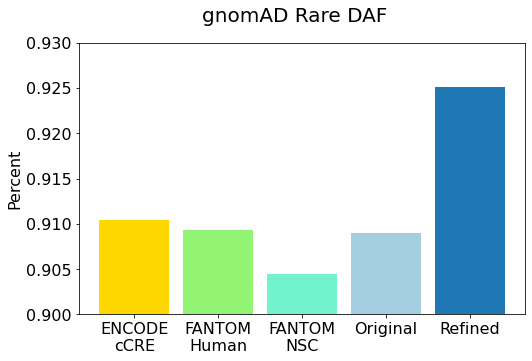

In [59]:
fig = plt.figure(figsize=(8, 5))
plt.bar(np.array([0, 0.3, 0.6, 0.9, 1.2]), 
        np.array([gnomad_encode,
                  gnomad_human, 
                  gnomad_nsc,
                  gnomad_original,
                  gnomad_refined
                 ]), 
        width = 0.25,
        color = ["#FFD700", "#93F372", "#72F3CE", "#A6CEE3", "#1F78B4"])
plt.xticks([0, 0.3, 0.6, 0.9, 1.2], ['ENCODE\ncCRE', 'FANTOM\nHuman', 'FANTOM\nNSC', 'Original', 'Refined'])
fig.suptitle('gnomAD Rare DAF', fontsize=20)
plt.ylim(0.9, 0.93)
plt.ylabel('Percent', fontsize=16)
plt.savefig('DECODE.gnomAD.rareDAF.pdf')

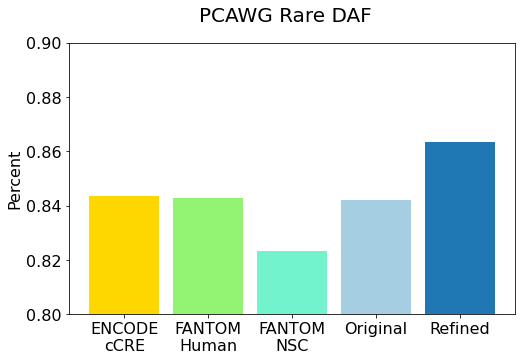

In [61]:
fig = plt.figure(figsize=(8, 5))
plt.bar(np.array([0, 0.3, 0.6, 0.9, 1.2]), 
        np.array([pcawg_encode,
                  pcawg_human, 
                  pcawg_nsc,
                  pcawg_original,
                  pcawg_refined
                 ]), 
        width = 0.25,
        color = ["#FFD700", "#93F372", "#72F3CE", "#A6CEE3", "#1F78B4"])
plt.xticks([0, 0.3, 0.6, 0.9, 1.2], ['ENCODE\ncCRE', 'FANTOM\nHuman', 'FANTOM\nNSC', 'Original', 'Refined'])
fig.suptitle('PCAWG Rare DAF', fontsize=20)
plt.ylim(0.8, 0.9)
plt.ylabel('Percent', fontsize=16)
plt.savefig('DECODE.pcawg.rareDAF.pdf')